# Data description

-----
title: ASD iPSC data annotation
author: Shaojie Ma
date: May 24, 2023
------


## Description of the seurat object
1. Object: Inte_CellCycle_SeuScore_Seurat_annotated.rds
	- Overview:
		- This object contains all the data and the seurat-corrected (with cell cycle correction) reduced dimensions. I used the scrublet to predict and remove doublets. 
	- Assays: 
		- RNA: this is the default filtered matrices from cellranger
		- DS: because some samples have low number of cells and high sequencing depther, I also use cellranger aggr function to downsample (DS) all samples to the same depth (same number of reads per cell)
	- Reduced dimensions:
		- pca: this is the batch- and cell-cycle-corrected reduced dimensions
		- umap: umap coordinates.
	- meta.data:
		- basic QC metrics: nCount/nFeature_RNA/DS, percent.mt (mitochondria), percent.ribo (ribosome)
		- cell_origin: sample name
		- time: days in vitro
		- condition: Ctrl or ASD
		- sampleid: sample ID
		- scrublet_score: scrublet doublet scores
		- scrublet_assign: the predicted doublets from scrublet. Note the doublet rate is very low (< 0.1%), whether you remove them or not will not make any differences to the results.
		- S.Score,G2M.Score,Phase: cell cycle scores and the predicted phases
		- RNA_snn_res.1 & seurat_clusters: the raw seurat clusters
		- anno_cell, anno_cluster: two sets of cell type annotations. They were overall the same except for the RG-like cells. Label transfer were applied for both sets of annotations. In the anno_cell annotation, the transfer was directly applied for each cell. In the anno_cluster annotation, the transfer was first applied to each cell and the most abundant identity in a given cluster was assigned as the identity of that cluster. Note that, in the anno_cluster annotation, those RG-like cells were sub-clustered to achieve better resolution.

In [1]:
n.cores <-  as.numeric(Sys.getenv('SLURM_CPUS_PER_TASK'))
n.cores <- if (!is.na(n.cores) & n.cores > 1) n.cores else parallel::detectCores()

options(future.globals.maxSize= 5*10^9)
future::plan(strategy = 'multicore', workers = n.cores)
BiocParallel::register(BiocParallel::MulticoreParam(n.cores))

# Libraries

In [2]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(ggrepel)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Data load

In [3]:
load('../data/commons.rda', verbose = T)

Loading objects:
  cell.type.colors
  cell.types
  cell.types.nohighmito
  chr_df
  donor_sex
  fig
  flora_paper_list
  gene_type.df
  imprinted.df
  imprinted.genes
  monkey_paper_list
  monkey.genes
  monkey.markers
  nescreg.genes
  nescreg.genes.no_trg
  nescreg.genes.no_trg.early
  nescreg.list
  nescreg.list.no_trg
  nescreg.list.no_trg.early
  nescreg.markers
  nescreg.markers.no_trg
  nescreg.markers.no_trg.early
  nicola_marker_list
  origin_sex.colors
  pat.de
  pat.de.top20
  pat.list
  pat.neu.de
  pat.neu.de.top20
  pat.neu.list
  pat.neu.top20
  pat.top20
  phases
  phases.colors
  protein_coding.genes
  region.genes
  region.list
  region.markers
  samples
  samples.colors
  sex_chr.genes
  sex_chr.genes.x
  sex_chr.genes.y
  shown_2b_list
  shown_4d_list
  tf.genes
  tfs.df
  top100.sub.pat
  top100.subtype
  valid_chr


In [4]:
seu.original <- readRDS('../raw/Inte_CellCycle_SeuScore_Seurat_annotated.rds')

Following Jay's advice, we are using the `DS` assay since it contains aggregated reads from CellRanger, which should correct differences in sequencing depth accross samples.

In [5]:
seu <- seu.original

In [6]:
DefaultAssay(seu) <- 'DS'
seu[['RNA']] <- NULL
seu[['RNA']] <- seu[['DS']]
DefaultAssay(seu) <- 'RNA'
seu[['DS']] <- NULL

Warning message:
“Cannot add objects with duplicate keys (offending key: ds_), setting key to 'rna_'”


## Metadata

In [8]:
# Vector of donor-condition equivalences
id_conditions <- with(unique(seu@meta.data[,c('cell_origin', 'condition')]),
                      {setNames(condition, cell_origin)})

id_conditions

D8_Ctrl_290 D8_Ctrl_311 D8_Ctrl_317  D8_ASD_375  D8_ASD_384  D8_ASD_494 
     "Ctrl"      "Ctrl"      "Ctrl"       "ASD"       "ASD"       "ASD"

In [9]:
seu$anno_cluster_fct <- factor(seu$anno_cluster, cell.types)

In [10]:
seu$origin_sex <- plyr::mapvalues(
    x=seu$cell_origin,
    from = names(donor_sex), 
    to=as.character(donor_sex)) %>% factor(levels=levels(donor_sex))

In [11]:
seu$anno_origin <- paste(seu$anno_cluster, seu$cell_origin)

### Supplementary table 7

In [12]:
seu@meta.data %>% arrange(anno_cluster_fct, cell_origin) %>% select(
'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'nCount_DS', 'nFeature_DS', 'cell_origin', 'time', 'condition', 'sampleid', 'scrublet_score', 'scrublet_assign', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.1.2', 'seurat_clusters', 'anno_cell', 'anno_cluster', 'origin_sex') -> dfs

dfs %>% mutate_if(.predicate = is.character, .funs = gsub, pattern='494', replacement='434', fixed=T) %>% mutate_if(.predicate = is.character, .funs = gsub, pattern='FGF17-like', replacement='PC FGF17-like', fixed=T) -> dfs # %>% select('anno_origin') %>% unique

# openxlsx::write.xlsx(dfs, '..//results//supp_table.6.D8_scRNA-Seq_metadata.xlsx', rowNames=T)

In [ ]:
read.table

# QC

In [18]:
table(seu$anno_cluster)


     FGF17-like       High-mito        Mes prog Neral crest/Mes          Neuron 
            288           12543            7056             215             717 
       RG early         RG late 
          32573            3462 

In [19]:
dim(seu)

[1] 37733 56854

In [20]:
subset(seu, anno_cluster !='High-mito')

An object of class Seurat 
37733 features across 44311 samples within 1 assay 
Active assay: RNA (37733 features, 0 variable features)
 1 dimensional reduction calculated: umap

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


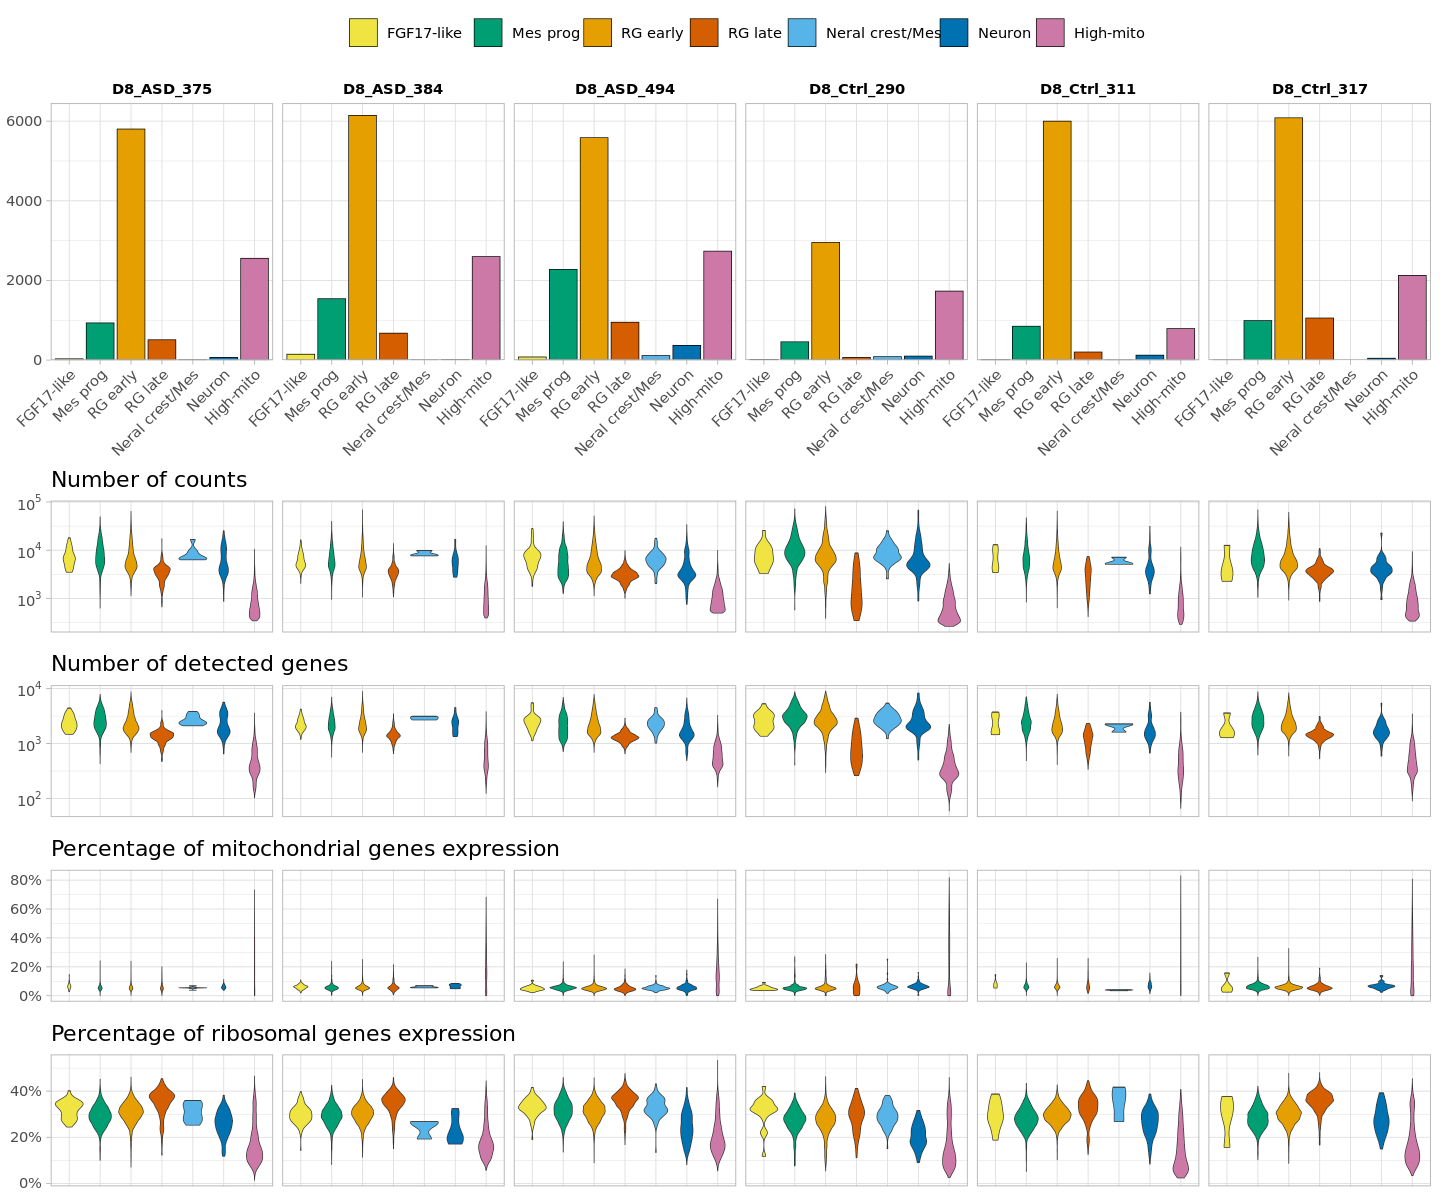

In [15]:
fig(12,10)

qc.labs <- c('nCount_DS'='Number of counts','nFeature_DS'='Number of detected genes','percent.mt'='Percentage of mitochondrial genes expression','percent.ribo'='Percentage of ribosomal genes expression')


p <- ggplot(seu@meta.data, aes(x=anno_cluster_fct, fill=anno_cluster_fct)) + 
    facet_grid(cols=vars(cell_origin)) +
    scale_fill_manual(values = cell.type.colors) + 
    theme_light() + 
    theme(strip.background = element_blank(), strip.text = element_text(color='black', face = 'bold'), axis.text.x = element_text(angle=45, hjust=1)) + labs(x=NULL, y=NULL)

p.list <- list()
p + geom_bar(linewidth=0.2, color='black')+
    labs(fill=NULL) +
    guides(fill=guide_legend(nrow = 1)) +
    scale_y_continuous(expand=expansion(mult=c(0,.05))) + 
    # scale_y_log10(expand=expansion(mult=c(0,0)), labels=scales::label_log()) + 
    theme(legend.position = 'top') -> p.list[['anno_dist']]

# 'nCount_RNA','nFeature_RNA','scrublet_score', 'S.Score', 'G2M.Score'
qc.vars <- c('nCount_DS','nFeature_DS','percent.mt','percent.ribo')

c(p.list, lapply(qc.vars,
    function(x){
    p + geom_violin(aes_string(y=x), draw_quantiles = T, linewidth=0.2) +
        ggtitle(qc.labs[x]) +
        theme(title = element_text(hjust=0), strip.text = element_blank(), legend.position = 'none', axis.ticks.x = element_blank(),axis.text.x = element_blank())
}) %>% setNames(nm=qc.vars)) -> p.list

p.list[c('nCount_DS','nFeature_DS')] %>% lapply(FUN=function(x){x+scale_y_log10(labels=scales::label_log())}) -> p.list[c('nCount_DS','nFeature_DS')]
p.list[c('percent.mt','percent.ribo')] %>% lapply(FUN=function(x){x+scale_y_continuous(labels=scales::label_percent(scale = 1))}) -> p.list[c('percent.mt','percent.ribo')]


cowplot::plot_grid(plotlist = p.list, ncol=1, axis = 'tblr', align = 'v', rel_heights = c(2.5, rep(1, length.out = length(p.list)-1))) -> ps.bydonor
ps.bydonor

In [16]:
library(ggh4x)

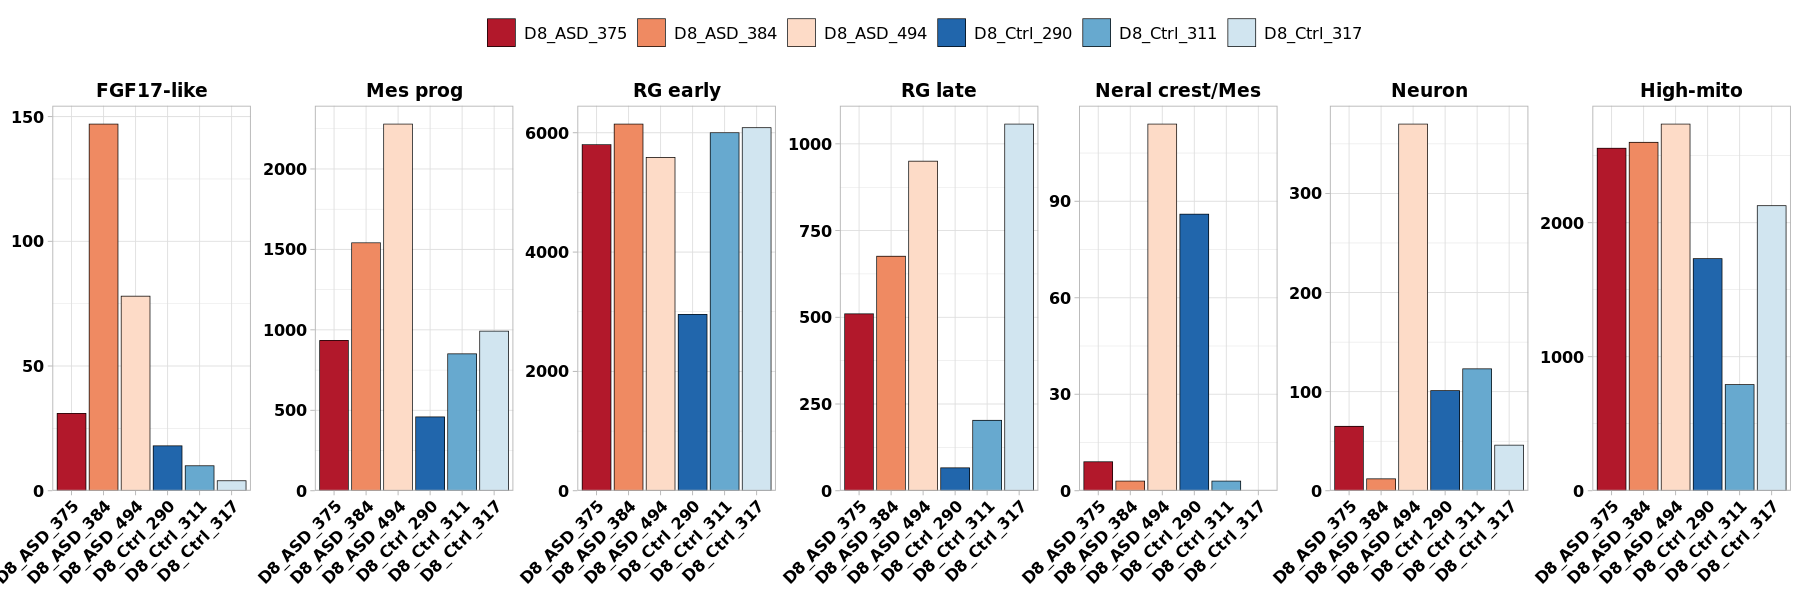

In [17]:
p <- ggplot(seu@meta.data, aes(x=cell_origin, fill=cell_origin)) + 
    facet_grid2(cols=vars(anno_cluster_fct), scales='free_y', independent='y') +
    scale_fill_manual(values = samples.colors) + 
    theme_light() + 
    theme(strip.background = element_blank(), strip.text = element_text(color='black', face = 'bold'), axis.text.x = element_text(angle=45, hjust=1)) + labs(x=NULL, y=NULL)
fig(15,5)
p + geom_bar(linewidth=0.2, color='black')+
    labs(fill=NULL) + labs_pubr() +
    guides(fill=guide_legend(nrow = 1)) +
    scale_y_continuous(expand=expansion(mult=c(0,.05))) + 
    # scale_y_log10(expand=expansion(mult=c(0,0)), labels=scales::label_log()) + 
    theme(legend.position = 'top') 


In [18]:
fig(22,10)
p <- ggplot(seu@meta.data, aes(x=cell_origin, fill=cell_origin)) + 
    facet_grid(cols=vars(anno_cluster_fct)) +
    scale_fill_manual(values = samples.colors) + 
    theme_light() + 
    theme(strip.background = element_blank(), strip.text = element_text(color='black', face = 'bold'), axis.text.x = element_text(angle=45, hjust=1)) + labs(x=NULL, y=NULL)

p.list <- list()
p + geom_bar(linewidth=0.2, color='black')+ 
    facet_grid2(cols=vars(anno_cluster_fct), scales='free_y', independent='y') +
    labs(fill=NULL) +
    guides(fill=guide_legend(nrow = 1)) +
    scale_y_continuous(expand=expansion(mult=c(0,.05))) + 
    # scale_y_log10(expand=expansion(mult=c(0,0)), labels=scales::label_log()) + 
    theme(legend.position = 'top') -> p.list[['donor_dist']]

# 'nCount_RNA','nFeature_RNA','scrublet_score', 'S.Score', 'G2M.Score'
qc.vars <- c('nCount_DS','nFeature_DS','percent.mt','percent.ribo')

c(p.list, lapply(qc.vars,
    function(x){
    p + geom_violin(aes_string(y=x), draw_quantiles = T, linewidth=0.2) +
        ggtitle(qc.labs[x]) +
        theme(title = element_text(hjust=0), strip.text = element_blank(), legend.position = 'none', axis.ticks.x = element_blank(),axis.text.x = element_blank())
}) %>% setNames(nm=qc.vars)) -> p.list

p.list[c('nCount_DS','nFeature_DS')] %>% lapply(FUN=function(x){x+scale_y_log10(labels=scales::label_log())}) -> p.list[c('nCount_DS','nFeature_DS')]
p.list[c('percent.mt','percent.ribo')] %>% lapply(FUN=function(x){x+scale_y_continuous(labels=scales::label_percent(scale = 1))}) -> p.list[c('percent.mt','percent.ribo')]


cowplot::plot_grid(plotlist = p.list, ncol=1, axis = 'tblr', align = 'v', rel_heights = c(2.5, rep(1, length.out = length(p.list)-1))) -> ps.byct

In [19]:
dir.create('../plots/qc/', recursive = T)
cairo_pdf('../plots/qc/qc_vars_overview.pdf', onefile = T, width = 12, height = 10)
plot(ps.bydonor)
plot(ps.byct)
dev.off()

Warning message in dir.create("../plots/qc/", recursive = T):
“'../plots/qc' already exists”


png 
  2

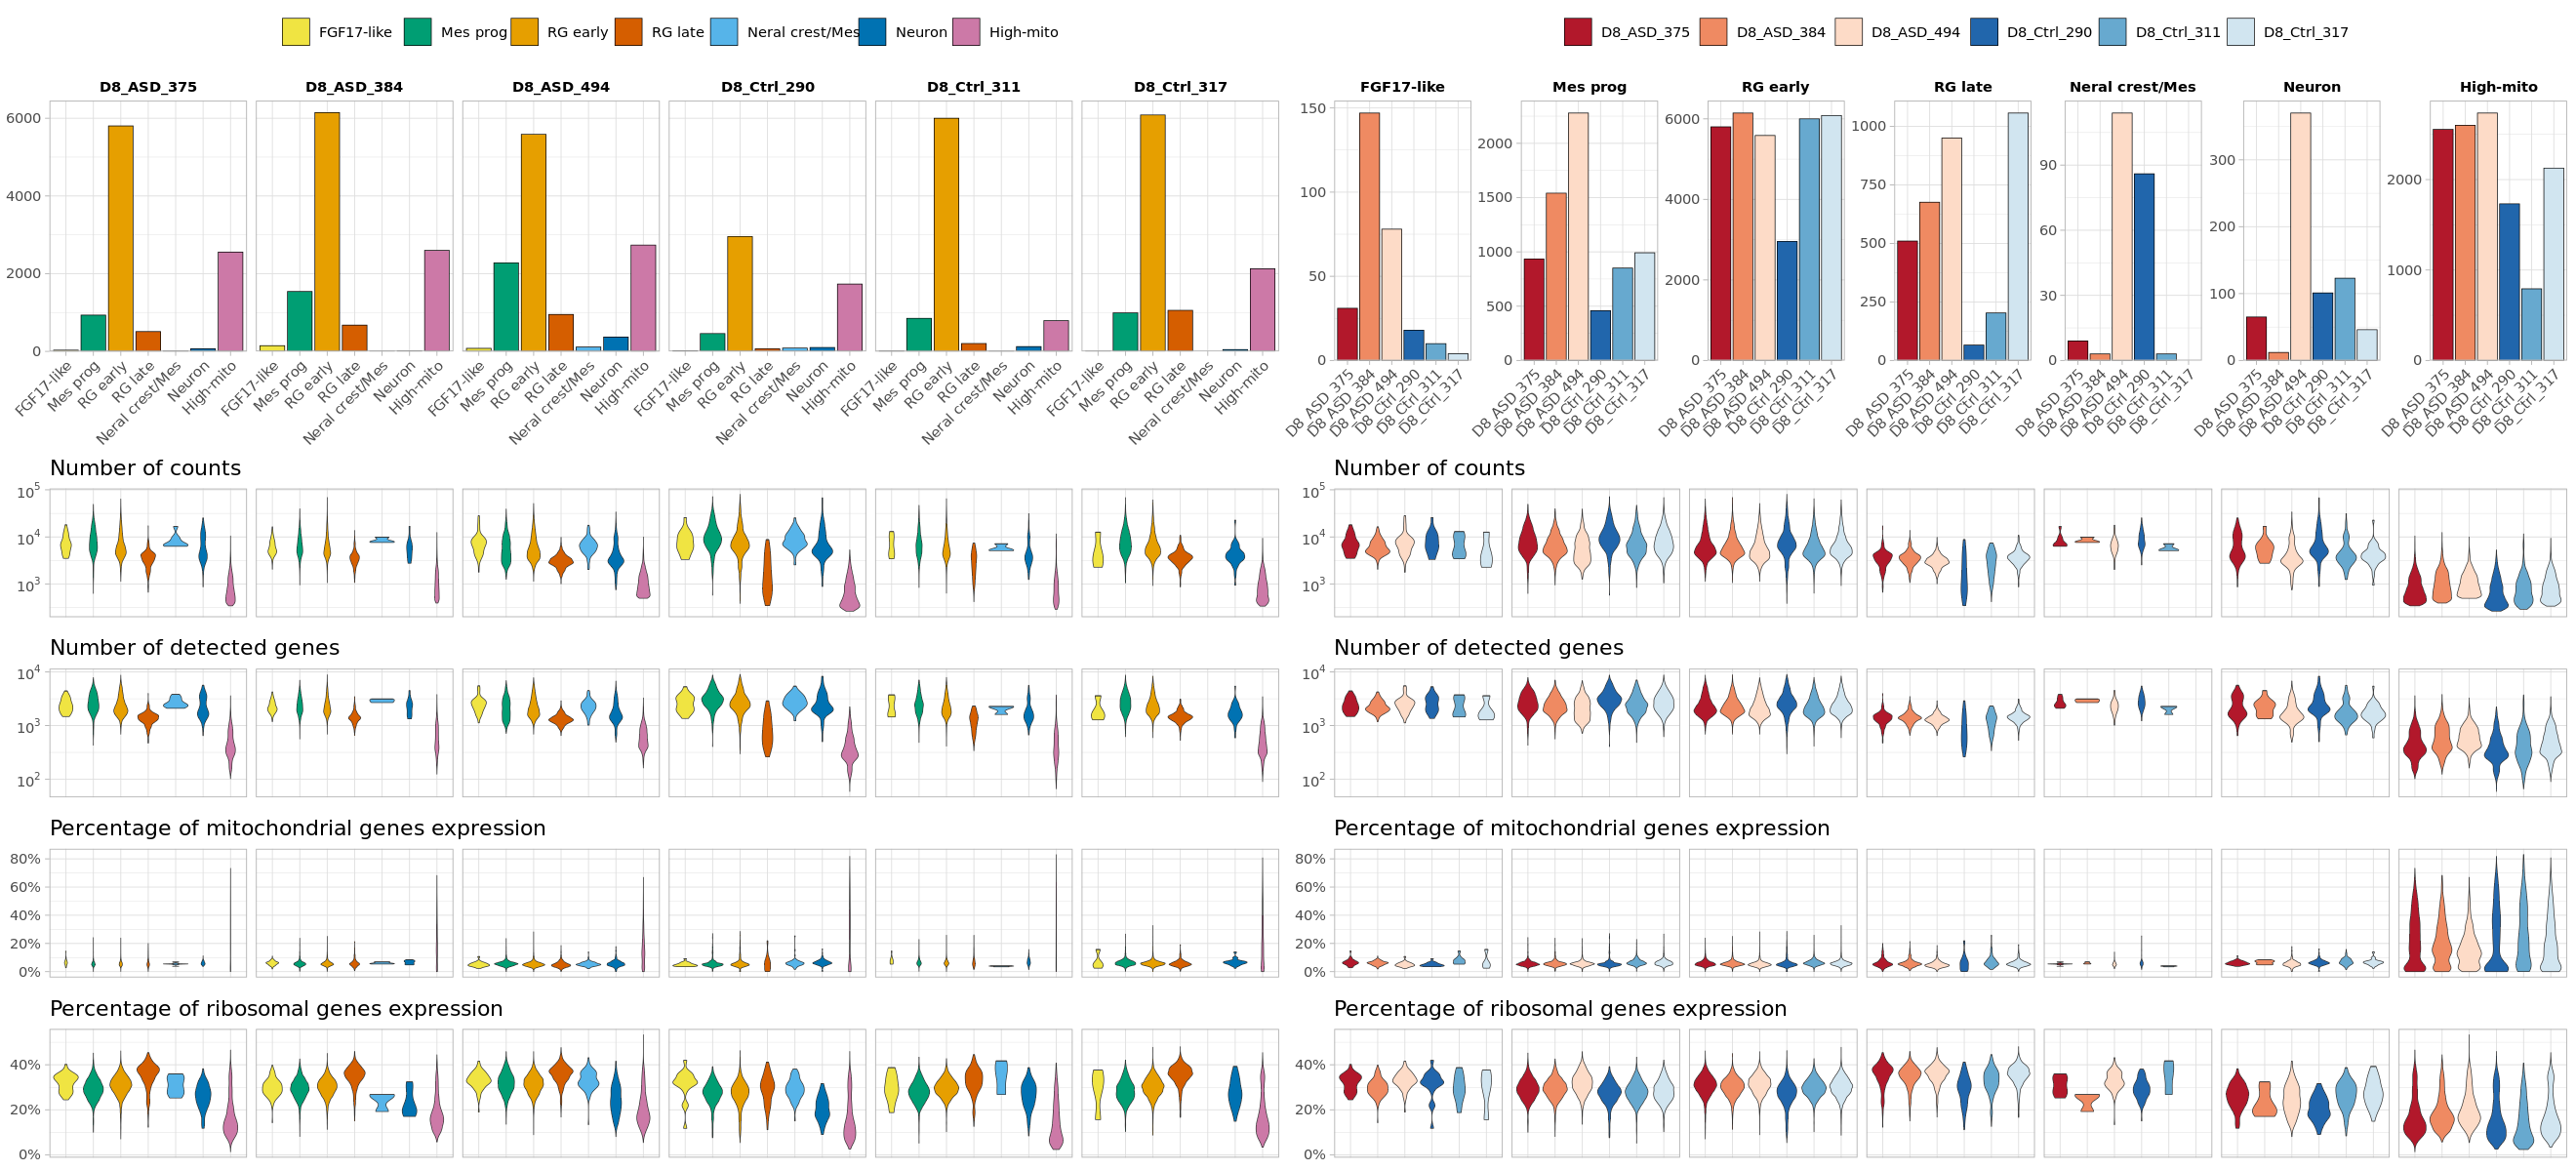

In [20]:
cowplot::plot_grid(ps.bydonor, ps.byct, nrow=1)

In [21]:

cairo_pdf('../plots/qc/clusters_map.pdf', onefile = T, width=7, height=7)

(DimPlot(subset(seu, anno_cluster_fct != 'High-mito'), group.by = 'anno_cluster_fct') + NoLegend() + scale_color_manual(values=cell.type.colors)) %>% LabelClusters(id='anno_cluster_fct')
(DimPlot(seu, group.by = 'anno_cluster_fct') + NoLegend() + scale_color_manual(values=cell.type.colors)) %>% LabelClusters(id='anno_cluster_fct')

(DimPlot(seu, group.by = 'seurat_clusters') + NoLegend()) %>% LabelClusters(id='seurat_clusters')

dev.off()

# $data %>% group_by(features.plot)

png 
  2

## Jay markers

In [22]:
# options(future.globals.maxSize=Inf)
# plan("multicore", workers = 90)

# seu <- FindVariableFeatures(seu, verbose = T)

# Idents(seu) <- 'seurat_clusters'
# nmarkers.df <- FindAllMarkers(seu, verbose = T)

In [23]:
# cmarkers <- list(
#     'c14' = c('STMN2', 'ELAVL3', 'NHLH1', 'ONECUT2', 'PSTPIP1', 'EBF3'),
#     'c8' = c('MT-ATP6', 'MT-CO2', 'MT-CO3', 'MALAT1', 'MT-ND6'),
#     'c17' = c('MT-ATP8', 'MT-CYB', 'MT-ND4', 'MT-ND3', 'MT-ND2'), 
#     'c10' = c('SLC15A3', 'PHOX2B','IGF2', 'H19', 'MIR217HG'),
#     'c13' = c('MYL4', 'ANKRD1', 'STOML3', 'ANXA1', 'NPPB'),
#     'c12' = c( 'JUN', 'HEXIM1', 'MAFB', 'BTG1-DT', 'ADAMTS1', 'SREBF2-AS1'),
#     'c16' = c('TFAP2B', 'ETS1', 'EDNRA', 'S100B', 'SOX10', 'FOXD3'), 
#     'c6' = c('H3C4', 'H4C4', 'H2AC11', 'H2AC4', 'H2BC18', 'H2BC7'), 
#     'c5' = c('H3C8', 'H2AC14', 'H2BC4', 'H2BC13', 'H2BC17'), 
#     'c2' = c('PRR11', 'PLK1', 'PIF1', 'INCENP', 'MLXIP', 'FAM83D'), 
#     'c1' = c('AURKA', 'CENPA', 'CDCA3', 'APOLD1'), 
#     'c15' = c('IRX3', 'WNT4', 'PAX3', 'WNT1', 'ZIC1', 'PCDH8'), 
#     'c3' = c('RPS4Y1', 'MCM6', 'DTL', 'UNG', 'BST2'),
#     'c4' = c('CCDC152', 'MCM5',  'FAM111B', 'E2F1'), 
#     'c11' = c('UBB', 'TMSB10', 'HNRNPA2B1', 'RPL31', 'RPL38', 'PTMS'), 
#     'c0' = c('IGFBP5', 'RPL7', 'NACA', 'RPS13', 'TPT1'), 
#     'c9' = c('LHX5-AS1', 'TAGLN', 'ACTC1', 'ACTA2', 'ACTA1', 'CNN1', 'CSRP1'), 
#     'c18' = c('FOS', 'FOSB', 'EGR3', 'NR4A1','ATF3'), 
#     'c7' = c('ARL6IP1', 'PTTG1', 'HMGB2', 'CCNB2', 'UBE2S', 'TUBA1B'))
# names(cmarkers) <- as.character(1:length(cmarkers))
mmarkers <- list(
    `Organizers` = c('FGF17','FGF8','FGF18','SP8','ZIC1','ZIC3','ZIC4','RSPO3','RSPO2','ARX','WNT2B','WNT8B','LMX1A','TTR','FOXJ1','BMP4','SHH','NKX2-1'),
    `RGCs` = c('SOX2','NES','VIM','PAX6','HMGA2','CCND1','STMN2','SLC1A3','HOPX','FABP7','PTN','NRG1','CRYAB','CXCL12'),
    `Cycling` = c('MKI67','TOP2A','HMGB2','CDK1','NUSAP1','PCNA','MCM5','TYMS','FEN1','MCM2','FN1'),
    `Mes` = c('LUM','FOXD3','PLP1'),
    `ExN` = c('EOMES','NEUROG1','ASCL1','NHLH1','PPP1R17','DCX','SLA','NEUROD4','NEUROD2','NEUROD6','SATB2','TLE4','SOX5','FEZF2','FOXP2'),
    `InN` = c('DLX1','DLX2','GAD1','GAD2','MEIS2','FOXP1'),
    `Gliogenesis` = c('OLIG2','PDGFRA','MOBP','MBP','AQP4','GFAP','PTPRC'),
    `Immune` = c('C1QB','C1QC','CLDN5'),
    `'Vasc` = c('FLT1','ACTA2','CEMIP')
)

In [24]:
(unique(seu@meta.data[,c('anno_cluster_fct', 'seurat_clusters')]) %>% arrange_all )$seurat_clusters %>% unique %>% as.character -> cl.order.anno
cl.order.anno <- as.character(
    c(18, 12, 6, 10, 19, 15, 16, 20, 2, 9, 11, 0, 5, 4, 3, 17, 13, 8, 1, 7, 14)
)
seu$seurat_clusters_fct <- factor(as.character(seu$seurat_clusters), cl.order.anno)


# with(nmarkers.df %>% subset((p_val_adj < 0.05)&(avg_log2FC>0.1))  %>% 
#      # arrange(abs(avg_log2FC)) %>% 
#      # arrange(p_val_adj) %>% 
#      arrange(desc(pct.1-pct.2)) %>% 
#      group_by(gene) %>% slice_head(n=1) %>% 
#      ungroup() %>% 
#      arrange(desc(avg_log2FC)) %>% 
#      group_by(cluster) %>%
#      slice_head(n=5) %>% 
#      ungroup() %>% 
#      arrange(p_val_adj) , 
#      {split(gene, cluster)})[cl.order.anno] -> nmarkers

In [25]:
custom_genes <- c("FGF17", "FGF8", "FGF18", "SP8", "ZIC1", "ZIC3", "ZIC4", "RSPO3", "RSPO2", "ARX", "WNT2B", "WNT8B", "LMX1A", "TTR", "FOXJ1", "BMP4", "SHH", "NKX2-1", "SOX2", "NES", "VIM", "PAX6", "HMGA2", "CCND1", "STMN2", "SLC1A3", "HOPX", "FABP7", "PTN", "NRG1", "CRYAB", "CXCL12", "MKI67", "TOP2A", "HMGB2", "CDK1", "NUSAP1", "PCNA", "MCM5", "TYMS", "FEN1", "MCM2", "FN1", "LUM", "FOXD3", "PLP1", "EOMES", "NEUROG1", "ASCL1", "NHLH1", "PPP1R17", "DCX", "SLA", "NEUROD4", "NEUROD2", "NEUROD6", "SATB2", "TLE4", "SOX5", "FEZF2", "FOXP2", "DLX1", "DLX2", "GAD1", "GAD2", "MEIS2", "FOXP1", "EGFR", "OLIG2", "PDGFRA", "MOBP", "MBP", "AQP4", "GFAP", "PTPRC", "C1QB", "C1QC", "CLDN5", "FLT1", "ACTA2", "CEMIP")#, "MT-ND1", "MT-ND2", "MT-CO1", "MT-CO2")
cls_ord <- as.character(c(0,1,3,4,11,5,2,9,18,10,13,19,8,20))#,6,7,12,14,15,16,17))
cls_ord.all <- as.character(c(0,1,3,4,11,5,2,9,18,10,13,19,8,20,6,7,12,14,15,16,17))

In [26]:
fig(6,5.5)
mt.genes <- grep(pattern='^MT-', rownames(seu), value=T)
FeaturePlot(object = seu, features = 'percent.mt',
            pt.size = 1, order = T, cols=c('#333333', 'red'))+theme_void()+ggtitle('% mito. counts')-> p
# cairo_pdf('../plots/qc/umap_mitochondrial.pdf', onefile = T, width = 6, height = 5)
# plot(p)
# dev.off()

seu$`% mito.\ncounts` <- seu$percent.mt
seu$`# genes\nexpressed` <- seu$nFeature_DS
seu$`# counts\ndetected` <- seu$nCount_DS


VlnPlot(object=seu, features = c('% mito.\ncounts', '# genes\nexpressed', '# counts\ndetected'), stack = T) +
    scale_y_discrete(limits = rev(cls_ord.all)) + NoLegend() + xlab(NULL) + ylab('Cluster') + labs_pubr() + RotatedAxis() -> p2

fig(3,6)
cairo_pdf('../plots/qc/violin_mito_counts_features.pdf', onefile = T, width = 3, height = 5)
plot(p2)
dev.off()

png 
  2

In [27]:
cairo_pdf('../plots/qc/umap_mitochondrial.extra.pdf', onefile = T, width = 6, height = 5)
plot(p)
FeaturePlot(object = seu, features = 'percent.mt', min.cutoff = 15, max.cutoff = 60,
            pt.size = 1, order = T, cols=c('#333333', 'red'))+theme_void()+ggtitle('% mito. counts (min.cutoff=15 max.cutoff=60)')
FeaturePlot(object = seu, features = 'nFeature_DS',
            pt.size = 1, order = T, cols=c('#333333', 'green'))+theme_void()+ggtitle('# genes detected')
FeaturePlot(object = seu, features = 'nCount_DS', max.cutoff = 20000, 
            pt.size = 1, order = T, cols=c('#333333', 'green'))+theme_void()+ggtitle('# counts (cutoff >20000)')

VlnPlot(object=seu, features = c('percent.mt', 'percent.ribo', 'nFeature_DS', 'nCount_DS'), stack = T) + 
    scale_y_discrete(limits = rev(cls_ord)) + NoLegend() + RotatedAxis()
VlnPlot(object=seu, features = mt.genes, stack = T) + 
    scale_y_discrete(limits = rev(cls_ord)) + NoLegend()
DotPlot(object=seu, features = mt.genes) + 
    scale_y_discrete(limits = rev(cls_ord)) + NoLegend() + RotatedAxis()
dev.off()

Warning message:
“Removed 50172 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 163059 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 91 rows containing missing values (`geom_point()`).”


png 
  2

In [28]:
fig(15,5.5)

asd <- ScaleData(seu[,(as.character(seu$seurat_clusters)%in%cls_ord)&(seu$condition == "ASD")], features = custom_genes)
ctrl <- ScaleData(seu[,(as.character(seu$seurat_clusters)%in%cls_ord)&(seu$condition == "Ctrl")], features = custom_genes)
seu.sub <- ScaleData(seu[,(as.character(seu$seurat_clusters)%in%cls_ord)], features = custom_genes)


Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix



In [29]:
p.asd <- DotPlot(asd, features = custom_genes, cols = c('lightgrey', 'red'), 
                 dot.scale = 5, scale.by = "size", dot.min = 0.025) +
    theme_classic()+
    RotatedAxis() + 
    scale_y_discrete(limits = rev(cls_ord)) +
    labs(title = paste0("Custom markers using only ASD samples")) +
    theme(axis.ticks = element_line(size = 0.2), axis.line = element_line(size = 0.2),
          axis.text.y = element_text(size = rel(0.8)), axis.text.x = element_text(size = rel(0.8)), axis.title = element_blank(), legend.position = "bottom")
exp.asd <- p.asd$data%>%group_by(features.plot) %>% summarise(exp=!all(is.na(pct.exp))) %>% subset(exp) %>%select(features.plot) %>% unlist(recursive=T) %>% as.character
p.asd$data <- subset(p.asd$data, features.plot%in%exp.asd)


p.ctrl <- DotPlot(ctrl, features = custom_genes, cols = c('lightgrey', 'red'), 
                 dot.scale = 5, scale.by = "size", dot.min = 0.025) +
    theme_classic()+
    RotatedAxis() + 
    scale_y_discrete(limits = rev(cls_ord)) +
    labs(title = paste0("Custom markers using only control samples")) +
    theme(axis.ticks = element_line(size = 0.2), axis.line = element_line(size = 0.2),
          axis.text.y = element_text(size = rel(0.8)), axis.text.x = element_text(size = rel(0.8)), axis.title = element_blank(), legend.position = "bottom")
exp.ctrl <- p.ctrl$data%>%group_by(features.plot) %>% summarise(exp=!all(is.na(pct.exp))) %>% subset(exp) %>%select(features.plot) %>% unlist(recursive=T) %>% as.character
p.ctrl$data <- subset(p.ctrl$data, features.plot%in%exp.ctrl)


p.all <- DotPlot(seu.sub, features = custom_genes, cols = c('lightgrey', 'red'), 
                 dot.scale = 5, scale.by = "size", dot.min = 0.025) +
    theme_classic()+
    RotatedAxis() + 
    scale_y_discrete(limits = rev(cls_ord)) +
    labs(title = paste0("Custom markers using ASD and control samples")) +
    theme(axis.ticks = element_line(size = 0.2), axis.line = element_line(size = 0.2),
          axis.text.y = element_text(size = rel(0.8)), axis.text.x = element_text(size = rel(0.8)), axis.title = element_blank(), legend.position = "bottom") + xlab('Gene') + ylab('Cluster') + labs_pubr() 

exp.all <- p.all$data%>%group_by(features.plot) %>% summarise(exp=!all(is.na(pct.exp))) %>% subset(exp) %>%select(features.plot) %>% unlist(recursive=T) %>% as.character
p.all$data <- subset(p.all$data, features.plot%in%exp.all)



cairo_pdf('../plots/qc/cluster_markers.pdf', onefile = T, width=10, height=4)
p.all
p.ctrl
p.asd
dev.off()

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 251 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 281 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 244 rows containing missing values (`geom_point()`).”


png 
  2

In [30]:
fig(13,6)
cairo_pdf('../plots/qc/cluster_markers_with_qc.pdf', onefile = T, width=13, height=6)
pp <- cowplot::plot_grid(p2, p.all, nrow=1, align = 'h', axis='tb', rel_widths = c(1,5))
plot(pp)
dev.off()

Warning message:
“Removed 251 rows containing missing values (`geom_point()`).”


png 
  2

In [31]:
p.asd <- DotPlot(asd, features = custom_genes, cols = c('lightgrey', 'red'), group.by='anno_cluster_fct',
                 dot.scale = 5, scale.by = "size", dot.min = 0.025) +
    theme_classic()+
    RotatedAxis() + 
    scale_y_discrete(limits = rev) +
    labs(title = paste0("Custom markers using only ASD samples")) +
    theme(axis.ticks = element_line(size = 0.2), axis.line = element_line(size = 0.2),
          axis.text.y = element_text(size = rel(0.8)), axis.text.x = element_text(size = rel(0.8)), axis.title = element_blank(), legend.position = "bottom")
exp.asd <- p.asd$data%>%group_by(features.plot) %>% summarise(exp=!all(is.na(pct.exp))) %>% subset(exp) %>%select(features.plot) %>% unlist(recursive=T) %>% as.character
p.asd$data <- subset(p.asd$data, features.plot%in%exp.asd)


p.ctrl <- DotPlot(ctrl, features = custom_genes, cols = c('lightgrey', 'red'), group.by='anno_cluster_fct',
                 dot.scale = 5, scale.by = "size", dot.min = 0.025) +
    theme_classic()+
    RotatedAxis() + 
    scale_y_discrete(limits = rev) +
    labs(title = paste0("Custom markers using only control samples")) +
    theme(axis.ticks = element_line(size = 0.2), axis.line = element_line(size = 0.2),
          axis.text.y = element_text(size = rel(0.8)), axis.text.x = element_text(size = rel(0.8)), axis.title = element_blank(), legend.position = "bottom")
exp.ctrl <- p.ctrl$data%>%group_by(features.plot) %>% summarise(exp=!all(is.na(pct.exp))) %>% subset(exp) %>%select(features.plot) %>% unlist(recursive=T) %>% as.character
p.ctrl$data <- subset(p.ctrl$data, features.plot%in%exp.ctrl)


p.all <- DotPlot(seu, features = custom_genes, cols = c('lightgrey', 'red'), group.by='anno_cluster_fct',
                 dot.scale = 5, scale.by = "size", dot.min = 0.025) +
    theme_classic()+
    RotatedAxis() + 
    scale_y_discrete(limits = rev) +
    labs(title = paste0("Custom markers using all cells")) +
    theme(axis.ticks = element_line(size = 0.2), axis.line = element_line(size = 0.2),
          axis.text.y = element_text(size = rel(0.8)), axis.text.x = element_text(size = rel(0.8)), axis.title = element_blank(), legend.position = "bottom")
exp.all <- p.all$data%>%group_by(features.plot) %>% summarise(exp=!all(is.na(pct.exp))) %>% subset(exp) %>%select(features.plot) %>% unlist(recursive=T) %>% as.character
p.all$data <- subset(p.all$data, features.plot%in%exp.all)



cairo_pdf('../plots/qc/cluster_markers.by_anno.pdf', onefile = T, width=15, height=5.5)
p.all
p.ctrl
p.asd
dev.off()

Warning message:
“Removed 125 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 101 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 102 rows containing missing values (`geom_point()`).”


png 
  2

# Export AnnData

In [32]:
if (!file.exists("../data/Inte_CellCycle_SeuScore_Seurat_annotated.DS.h5ad")){
    print('Creating h5ad version of the data')
    SeuratDisk::SaveH5Seurat(seu, filename = "../data/Inte_CellCycle_SeuScore_Seurat_annotated.DS.h5Seurat", verbose=T, overwrite = T)
    SeuratDisk::Convert("../data/Inte_CellCycle_SeuScore_Seurat_annotated.DS.h5Seurat", dest = "h5ad", verbose=T, overwrite = T)
}

# Preprocessing

## Full dataset

In [ ]:
# Normalize expression
seu <- NormalizeData(seu, normalization.method = "LogNormalize", scale.factor = 10000, verbose=TRUE)

# Scale normalized expression of all genes
all.genes <- rownames(seu)
seu <- ScaleData(seu, features = all.genes, verbose=TRUE)

Centering and scaling data matrix



In [ ]:
# Save file
if (!file.exists("../data/DE_DS.pp.scaled.RDS")){
    saveRDS(seu, '../data/DE_DS.pp.scaled.RDS')
}

## No High-mitochondrial

In [24]:
seu2 <- subset(seu, anno_cluster != 'High-mito')

In [16]:
seu2[['umap_original']] <- seu2[['umap']]

Warning message:
“Cannot add objects with duplicate keys (offending key: UMAP_), setting key to 'umap_original_'”


In [17]:
seu2

An object of class Seurat 
37733 features across 44311 samples within 1 assay 
Active assay: RNA (37733 features, 0 variable features)
 2 dimensional reductions calculated: umap, umap_original

In [18]:
# Normalize expression
seu2 <- NormalizeData(seu2, normalization.method = "LogNormalize", scale.factor = 10000, verbose=TRUE)

# Scale normalized expression of all genes
all.genes <- rownames(seu2)
seu2 <- ScaleData(seu2, features = all.genes, verbose=TRUE)

Centering and scaling data matrix



## Early Radial Glia

In [17]:
seu3 <- subset(seu, anno_cluster == 'RG early')

In [18]:
seu3

An object of class Seurat 
37733 features across 32573 samples within 1 assay 
Active assay: RNA (37733 features, 0 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [19]:
# Normalize expression
seu3 <- NormalizeData(seu3, normalization.method = "LogNormalize", scale.factor = 10000, verbose=TRUE)

# Scale normalized expression of all genes
all.genes <- rownames(seu3)
seu3 <- ScaleData(seu3, features = all.genes, verbose=TRUE)

Centering and scaling data matrix



In [20]:
seu3 <- FindVariableFeatures(verbose = T) %>% 
    RunPCA(verbose = T, npcs = 30) %>%
    FindNeighbors(verbose = T, dims = 1:30)

Centering and scaling data matrix

PC_ 1 
Positive:  RPL19, RPL7A, RPL29, RPS3, RPL8, RPL12, RPS6, FTL, GAPDH, TMSB10 
	   EEF1A1, TUBA1A, SNHG29, ENSG00000272449, EIF4A1, GSTP1, NME2, MDK, MYL6, GADD45G 
	   ID3, TUBB3, CA4, RPLP0, SNHG3, GNG8, ENSG00000239922, CCK, BST2, BTF3 
Negative:  CENPF, TOP2A, MKI67, ASPM, TPX2, CENPE, SMC4, NUSAP1, DLGAP5, UBE2C 
	   KIF11, KPNA2, KIF20B, SYNE2, BUB1B, CKAP2, GTSE1, PRC1, CCNB1, PIF1 
	   AURKA, SGO2, MIS18BP1, NES, HMGB2, CDCA8, MAP1B, CDK1, KIF23, NCAPG 
PC_ 2 
Positive:  TUBA1B, H4C3, UBE2S, TOP2A, HMGB2, TUBB4B, UBE2C, H3C4, CKS1B, PTTG1 
	   NUSAP1, H1-5, H3C2, CKS2, H2AZ1, KPNA2, TPX2, CCNB1, CDC20, AURKB 
	   DLGAP5, BIRC5, H2AC11, H2AC20, H2AX, HMGB1, H1-3, H4C4, PLK1, H1-2 
Negative:  IGFBP5, MIAT, HNRNPU, SNHG14, GOLGB1, NAP1L1, GABPB1-AS1, SULF1, CECR2, SOX11 
	   SESN3, GJA1, DST, AKAP9, DPYSL3, TOP2B, ATRX, CEMIP2, CCND2, CDH2 
	   PNN, PBX1, ANK2, NCL, PABPC1, GTF2I, SYNE2, KCNQ1OT1, EEF1A1, SMARCA5 
PC_ 3 
Positive:  WLS, LHX5

In [21]:
# Save file
if (!file.exists("../data/DE_DS.RGearly.pp.scaled.RDS")){
    saveRDS(seu3, '../data/DE_DS.RGearly.pp.scaled.RDS')
}

## Remove ASD donor 384

In [22]:
seu4 <- subset(seu2, cell_origin != 'D8_ASD_384')
seu4$cell_origin %>% unique()

seu4

[1] "D8_Ctrl_290" "D8_Ctrl_311" "D8_Ctrl_317" "D8_ASD_375"  "D8_ASD_494"

An object of class Seurat 
37733 features across 35787 samples within 1 assay 
Active assay: RNA (37733 features, 0 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [23]:
unique(seu4$anno_cluster_fct)

[1] Mes prog        RG early        Neuron          RG late        
[5] FGF17-like      Neral crest/Mes
7 Levels: FGF17-like Mes prog RG early RG late Neral crest/Mes ... High-mito

In [24]:
seu4 <- ScaleData(seu4, verbose = T) %>% 
    FindVariableFeatures(verbose = T)

Centering and scaling data matrix



In [25]:
# Save file
if (!file.exists("../data/DE_DS.no_ASD_384.pp.scaled.RDS")){
    saveRDS(seu4, '../data/DE_DS.no_ASD_384.pp.scaled.RDS')
}

# Figures

In [21]:
library(ggrepel)

In [22]:
col2hex <- function(x, alpha.pct=1, maxColorValue=255){
    co <- col2rgb(x)
    return(rgb(co[1], co[2], co[3], alpha = alpha.pct*maxColorValue, maxColorValue = maxColorValue))
}
col2hex('lightyellow', alpha.pct = .2)

[1] "#FFFFE033"

In [23]:
dir.create('../plots/umaps/')

Warning message in dir.create("../plots/umaps/"):
“'../plots/umaps' already exists”


In [25]:
umap <- read.csv('../data/DE_DS.NoHighMito.pp.umap.csv', row.names=1)
umap<- cbind(umap[colnames(seu2),], seu2@meta.data)


## Panel A

In [31]:
umap %>% group_by(anno_cluster_fct)%>% summarise_at(median, .vars=vars(UMAP_1, UMAP_2)) -> umap_labels

fig(7,8)

ggplot(umap, aes(x=UMAP_1, y=UMAP_2, color=anno_cluster_fct)) +
    ggtitle('Cell type') + 
    geom_point(size=1.5, shape=16, 
               alpha=0.7,
               stroke=0
              ) +
    scale_color_manual('Cell type', values=cell.type.colors) +
    guides(color = guide_legend(override.aes = list(size = 5, alpha=1)))  +
    theme_void()  +
    theme(panel.background = element_rect(fill=col2hex('black',alpha.pct = 0),
                                          color='transparent'),
          text=element_text(family='ArialMT'), 
          legend.position = 'bottom',
          legend.text = element_text(size=12, family='ArialMT'), 
          legend.title = element_text(size=12, family='ArialMT', face='bold')) -> p1


p1.labeled <- p1 +
    geom_label_repel(
        box.padding = 1,
        data=umap_labels, 
        aes(label=anno_cluster_fct),
        color='black', fill='#FFFFFFA0',
        family = 'ArialMT', size=5)

pdf('../plots/umaps/celltype_umap.pdf', height=7, width=6, useDingbats = T, useKerning = F)
p1.labeled
dev.off()
pdf('../plots/umaps/celltype_donorsplit_umap.pdf', height=7, width=9, useDingbats = T, useKerning = F)
p1  + facet_wrap(~cell_origin)
dev.off()

png 
  2

png 
  2

In [11]:
lapply(samples, function(donor){
    pal <- c(
            paste0(
                if(grepl('ASD', donor)){samples.colors[1]}else{samples.colors[4]},
                'A0'), 'white')
    umap$pid <- factor(ifelse(umap$cell_origin == donor, donor, 'Rest'))
    ggplot(umap %>% arrange(desc(pid)),
           aes(x=UMAP_1, y=UMAP_2, color=pid, fill=pid)) +
        # ggtitle(glue::glue('{donor} density')) + 
        geom_point(size=1,
                   color=col2hex('black', alpha.pct = .2),
                   shape=21, 
                   # alpha=0.7, 
                   stroke=.5) +
        scale_fill_manual('Donor', values=pal) +
        guides(fill = guide_legend(override.aes = list(size = 5, alpha=1)))  +
        theme_void()  +
        theme(panel.background = element_rect(fill=col2hex('black',alpha.pct = 0),
                                              color='transparent'),
              text=element_text(family='ArialMT'), 
              legend.position = 'bottom',
              legend.text = element_text(size=12, family='ArialMT'), 
              legend.title = element_text(size=12, family='ArialMT', face='bold')) -> p
    p
}) %>% ggpubr::ggarrange(plotlist = .) -> donor_density

png 
  2

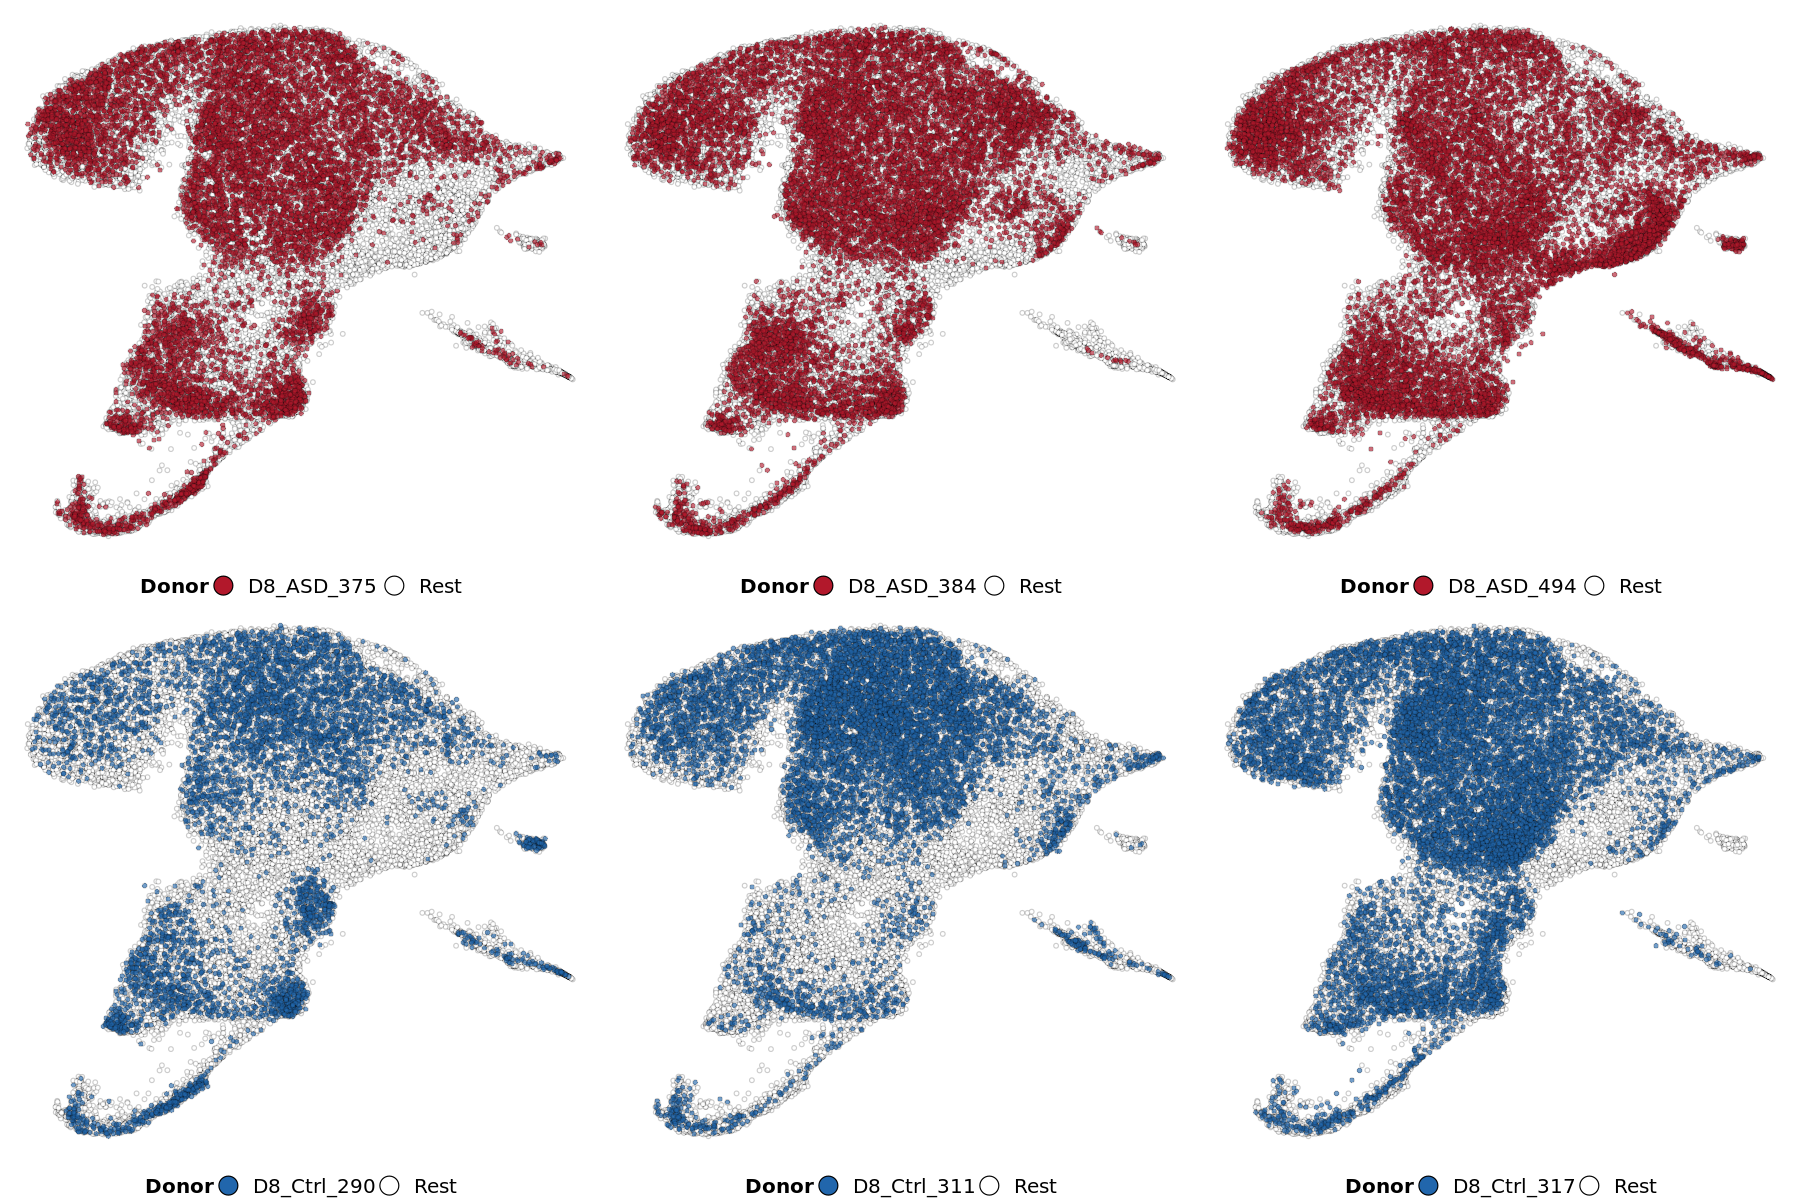

In [43]:
fig(15,10)
donor_density

png('../plots/umaps/donor_densities_umap.png',height = 10*500, width=15*500, res =500, )
# , useDingbats = T, useKerning = F)
plot(donor_density)
dev.off()

## Supp

### Phase

#### phase-color

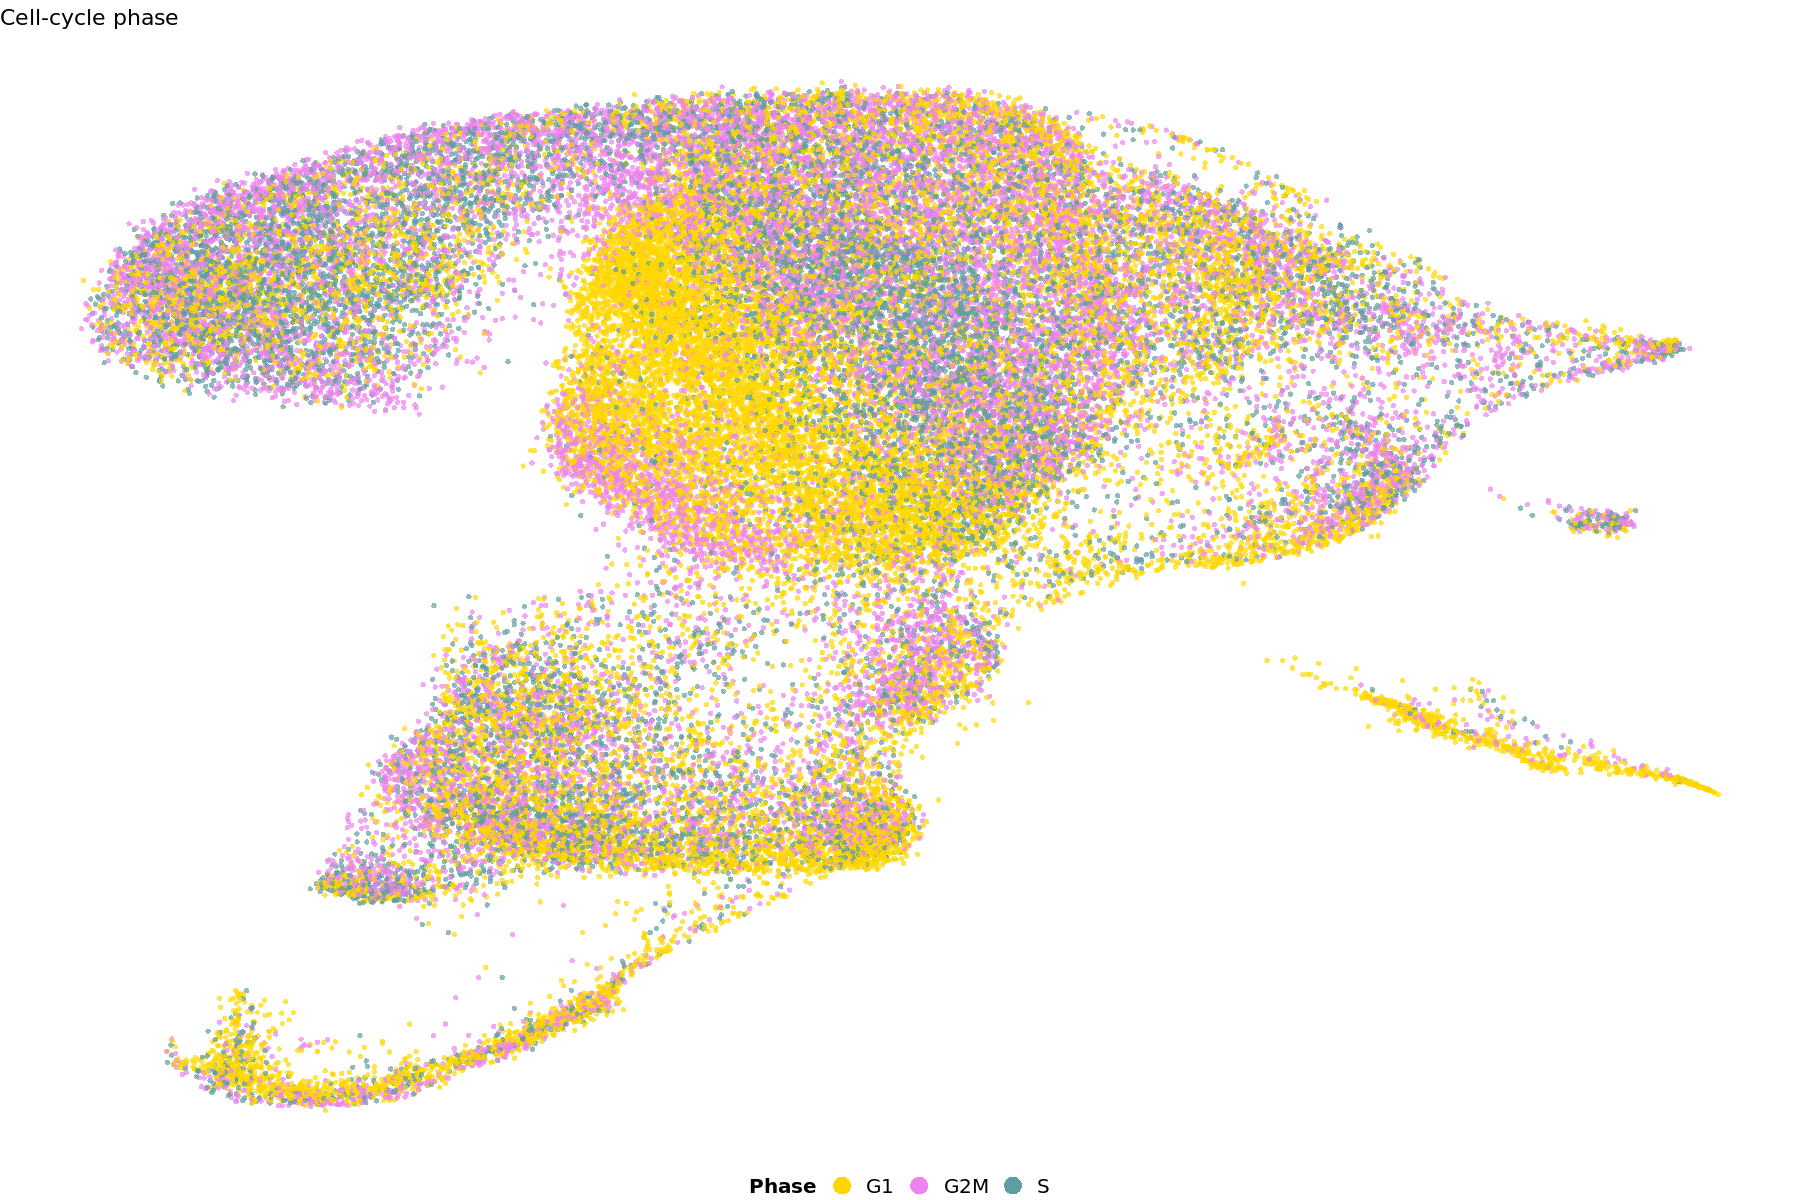

In [44]:
ggplot(umap, aes(x=UMAP_1, y=UMAP_2, color=Phase)) +
    ggtitle('Cell-cycle phase') + 
    geom_point(size=1.5, shape=16, 
               alpha=0.7, stroke=.01) +
    scale_color_manual('Phase', values=phases.colors) +
    guides(color = guide_legend(override.aes = list(size = 5, alpha=1))) +
    theme_void()  +
    theme(panel.background = element_rect(fill=col2hex('black',alpha.pct = 0),
                                          color='transparent'),
          text=element_text(family='ArialMT'), 
          legend.position = 'bottom',
          legend.text = element_text(size=12, family='ArialMT'), 
          legend.title = element_text(size=12, family='ArialMT', face='bold')) -> p2
p2

In [50]:
pdf('../plots/umaps/cellcycle_umap.pdf', height=6, width=6)
plot(p2)
dev.off()
pdf('../plots/umaps/cellcycle_donorsplit_umap.pdf', height=7, width=9, useDingbats = T, useKerning = F)
plot(p2  + facet_wrap(~cell_origin))
dev.off()

png 
  2

png 
  2

#### phase-densities

png 
  2

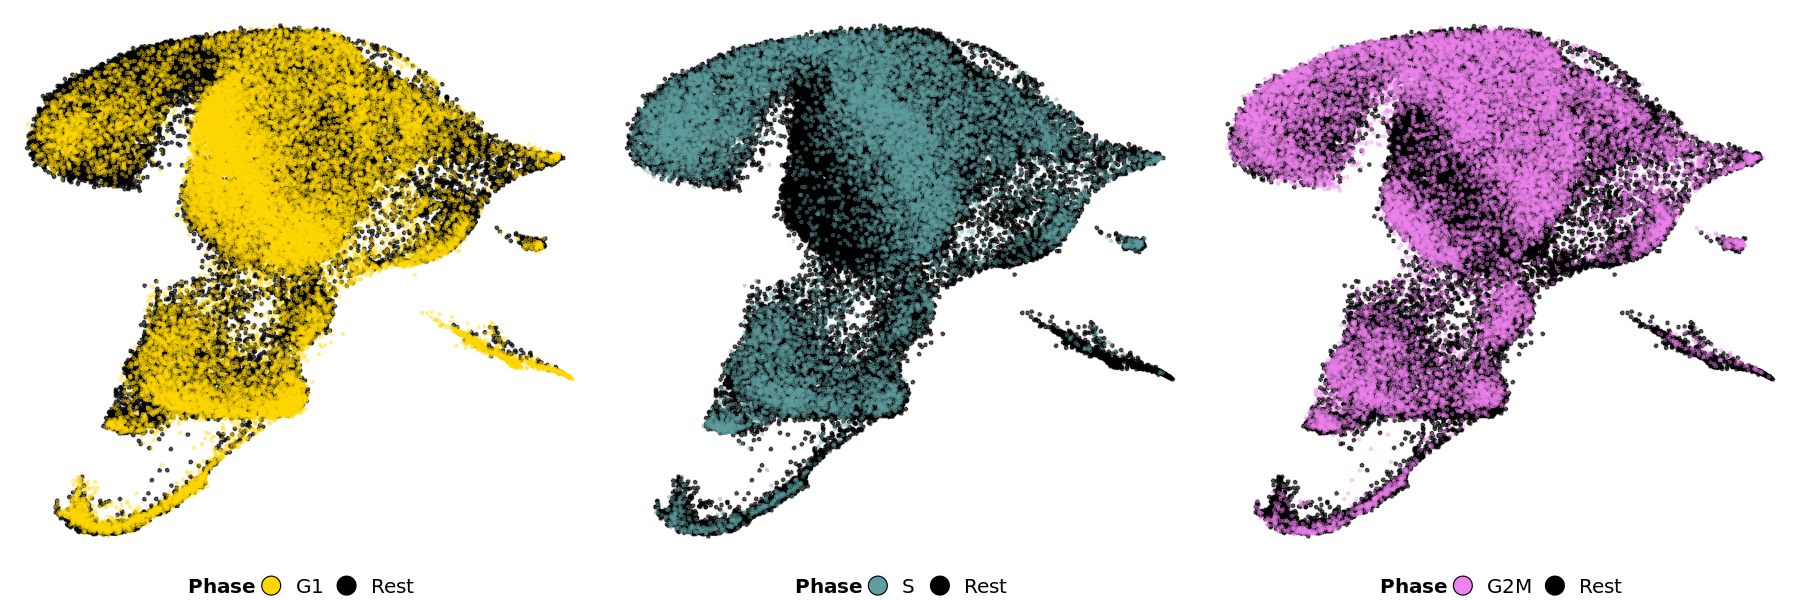

In [46]:
lapply(phases, function(phase){
    fill_pal <- c(col2hex(phases.colors[phase], alpha.pct = 0.4), col2hex('black', alpha.pct = 0.7))
    col_pal <- c(col2hex(phases.colors[phase], alpha.pct = 0.1), col2hex('black', alpha.pct = .4))
    umap$pid <- factor(ifelse(umap$Phase == phase, phase, 'Rest'), levels=c(phase, 'Rest'))
    ggplot(umap %>% arrange(desc(pid)),
           aes(x=UMAP_1, y=UMAP_2, color=pid, fill=pid)) +
        # ggtitle(glue::glue('{donor} density')) + 
        geom_point(size=.8,
                   # color=col2hex('black', alpha.pct = .2),
                   shape=21, 
                   # alpha=0.7, 
                   stroke=.5) +
        scale_fill_manual('Phase', values=fill_pal) +
        scale_color_manual('Phase', values=col_pal) +
        guides(color = guide_none(), fill = guide_legend(override.aes = list(size = 5, alpha=1)))  +
        theme_void()  +
        theme(panel.background = element_rect(fill=col2hex('black',alpha.pct = 0),
                                              color='transparent'),
              text=element_text(family='ArialMT'), 
              legend.position = 'bottom',
              legend.text = element_text(size=12, family='ArialMT'), 
              legend.title = element_text(size=12, family='ArialMT', face='bold')) -> p
    p
}) %>% ggpubr::ggarrange(plotlist = ., nrow = 1) -> phase_density

fig(15,5)
phase_density

png('../plots/umaps/cellcycle_densities_umap.png', height = 5*500, width=15*500, res =500)
# , useDingbats = T, useKerning = F)
plot(phase_density)
dev.off()

#### phase-blend

In [51]:
p3 <- FeaturePlot(
    seu, features = c('S.Score', 'G2M.Score'),
    order= T,
    blend=T, 
    pt.size = .2,
    # max.cutoff = 'q95',
    cols=c('lightgrey', phases.colors['S'], phases.colors['G2M']))
    # cols=c('lightgrey', 'blue', 'Red'))

In [52]:
pdf('../plots/umaps/cellcycle_blend_umap.pdf', height=6, width=20)
plot(p3)
dev.off()

png 
  2

### Clusters

In [54]:
umap %>% group_by(seurat_clusters)%>% summarise_at(median, .vars=vars(UMAP_1, UMAP_2)) -> umap_labels_clusters

In [56]:
fig(7,8)

ggplot(umap, aes(x=UMAP_1, y=UMAP_2, color=seurat_clusters)) +
    ggtitle('Clusters') + 
    geom_point(size=1.5, shape=16, 
               alpha=0.7,
               stroke=0
              ) +
    # scale_color_manual('Clusters', values=cell.type.colors) +
    guides(color = guide_legend(override.aes = list(size = 5, alpha=1), nrow = 3))  +
    theme_void()  +
    theme(panel.background = element_rect(fill=col2hex('black',alpha.pct = 0),
                                          color='transparent'),
          text=element_text(family='ArialMT'), 
          legend.position = 'bottom',
          legend.text = element_text(size=12, family='ArialMT'), 
          legend.title = element_text(size=12, family='ArialMT', face='bold')) -> p4


p4.labeled <- p4 +
    geom_label_repel(
        box.padding = 1,
        data=umap_labels_clusters, 
        aes(label=seurat_clusters),
        color='black', fill='#FFFFFFA0',
        family = 'ArialMT', size=5)

cairo_pdf('../plots/umaps/clusters_umap.pdf', height=7, width=6, onefile=T)
p4.labeled
dev.off()
cairo_pdf('../plots/umaps/clusters_donorsplit_umap.pdf', height=7, width=9, onefile=T)
p4  + facet_wrap(~cell_origin)
dev.off()

png 
  2

png 
  2

# Tables

In [40]:
donor_cluster_table <- as.data.frame(table(seu@meta.data[c('anno_cluster_fct', 'cell_origin')])) %>%
    reshape2::dcast('cell_origin ~ anno_cluster_fct', value.var='Freq')
donor_cluster_table

write.csv(donor_cluster_table, file='../data/donor_cluster_table.csv')

cell_origin FGF17-like Mes prog RG early RG late Neral crest/Mes Neuron
1 D8_ASD_375   31         934     5802      510      9              65   
2 D8_ASD_384  147        1541     6145      676      3              12   
3 D8_ASD_494   78        2279     5587      950    114             370   
4 D8_Ctrl_290  18         459     2955       66     86             101   
5 D8_Ctrl_311  10         851     6000      203      3             123   
6 D8_Ctrl_317   4         992     6084     1057      0              46   
  High-mito
1 2556     
2 2600     
3 2736     
4 1732     
5  792     
6 2127

In [41]:
donor_phase_table <- as.data.frame(table(seu@meta.data[c('Phase', 'cell_origin')])) %>%
    reshape2::dcast('cell_origin ~ Phase', value.var='Freq')
donor_phase_table

write.csv(donor_phase_table, file='../data/donor_phase_table.csv')

cell_origin G1   G2M  S   
1 D8_ASD_375  4310 3086 2511
2 D8_ASD_384  5228 3535 2361
3 D8_ASD_494  5901 3709 2504
4 D8_Ctrl_290 1888 1725 1804
5 D8_Ctrl_311 2930 2720 2332
6 D8_Ctrl_317 4142 3260 2908

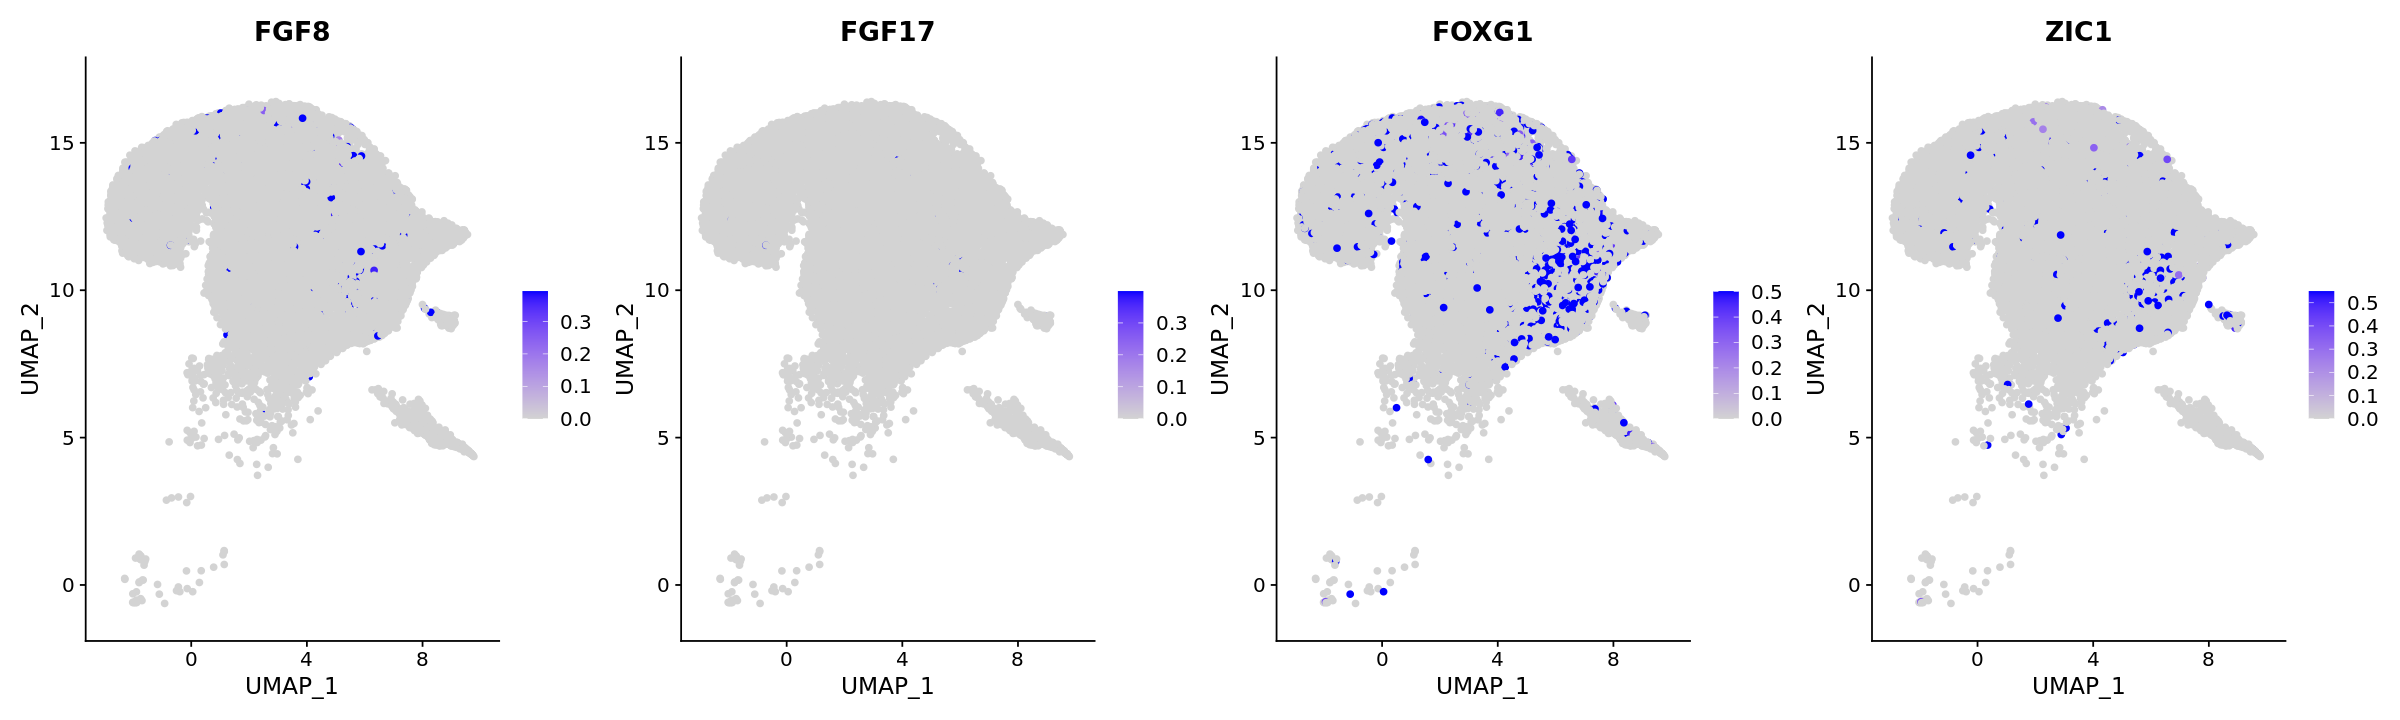

In [42]:
fig(20,6)

FeaturePlot(seu2, c('FGF8', 'FGF17', 'FOXG1', 'ZIC1'), ncol = 4, pt.size = 1.5, max.cutoff = 'q9')

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



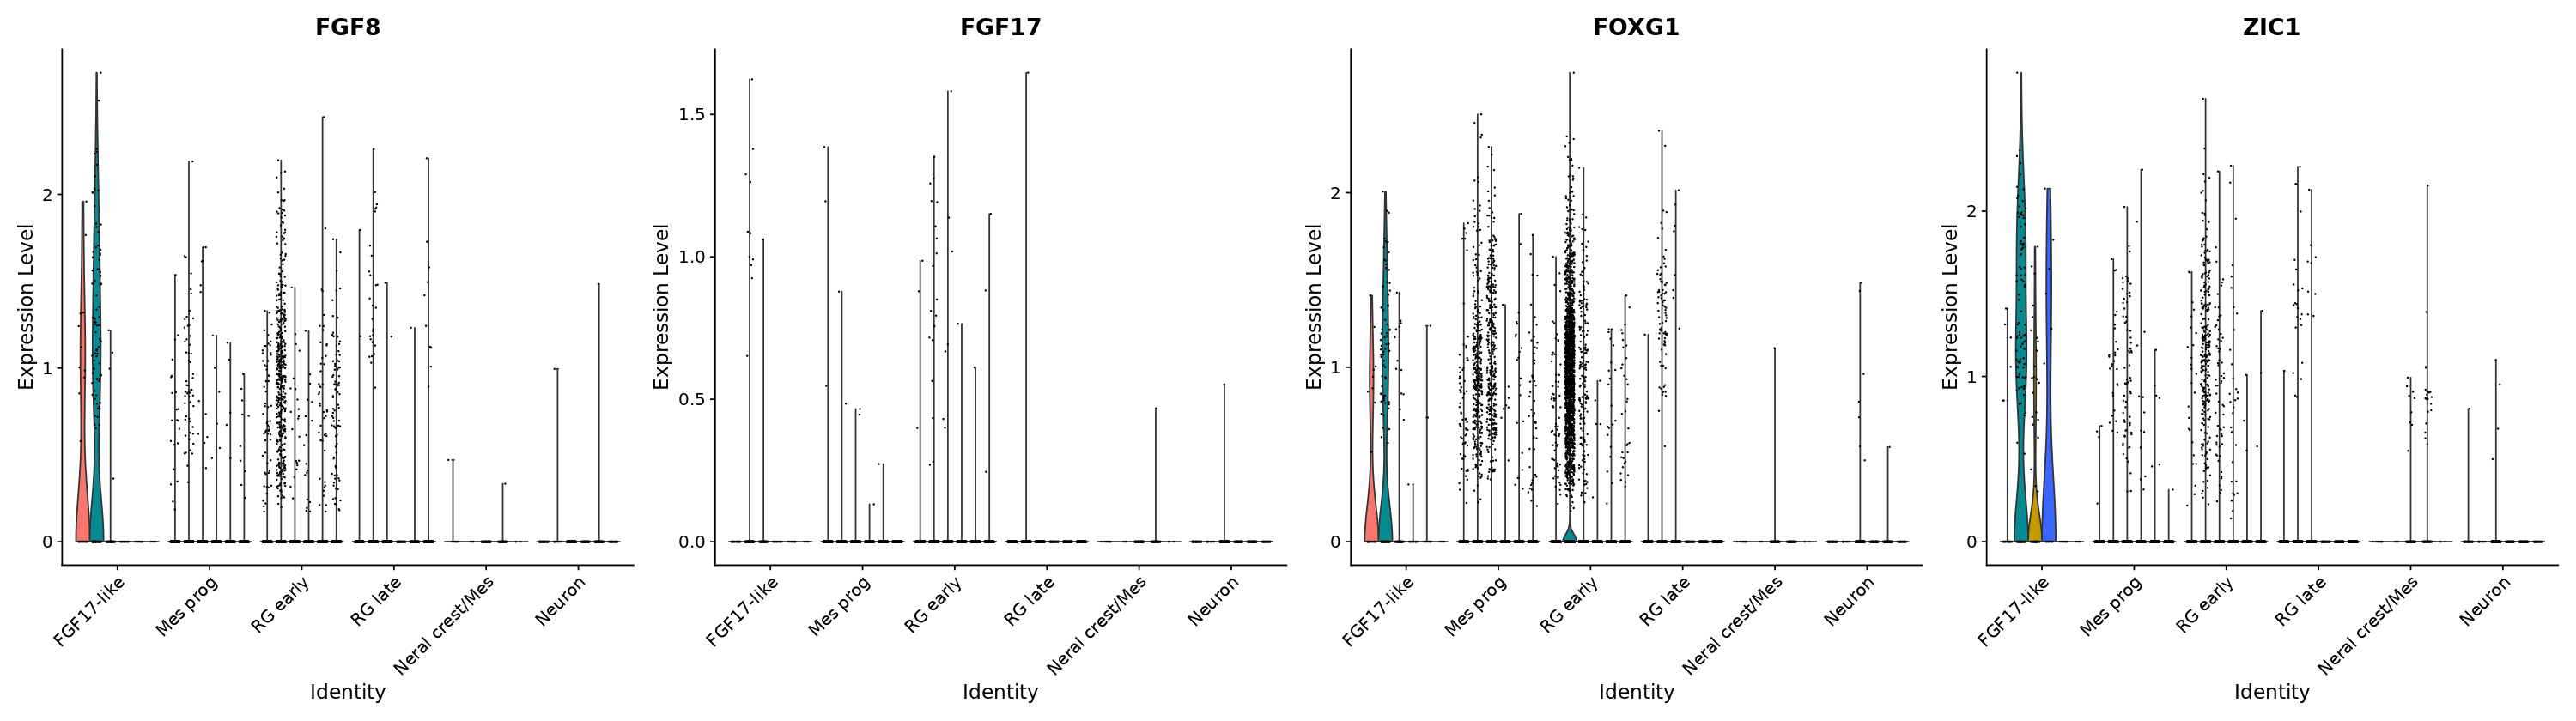

In [43]:
fig(25,7)
VlnPlot(seu2, c('FGF8', 'FGF17', 'FOXG1', 'ZIC1'), split.by='cell_origin', group.by='anno_cluster_fct', ncol = 4)


In [44]:
fig()
DotPlot(seu2, features = c('FGF8', 'FGF17', 'FOXG1', 'ZIC1'), group.by='anno_cluster_fct')

ERROR: Error in fig(): argument "w" is missing, with no default
